In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import titanlibcustom

In [3]:
# Import Formatted Data and functions from other Python script
from Data_Importation_and_Function_Definition import ROI_counties, NI_counties, rain_wow_comp, temp_wow_comp, rain_official_comp, temp_official_comp, isolate_data_of_interest, plot_wow_data

In [4]:
gdf_temp_wow, gdf_temp_official, gdf_temp_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_plot="Air Temperature")

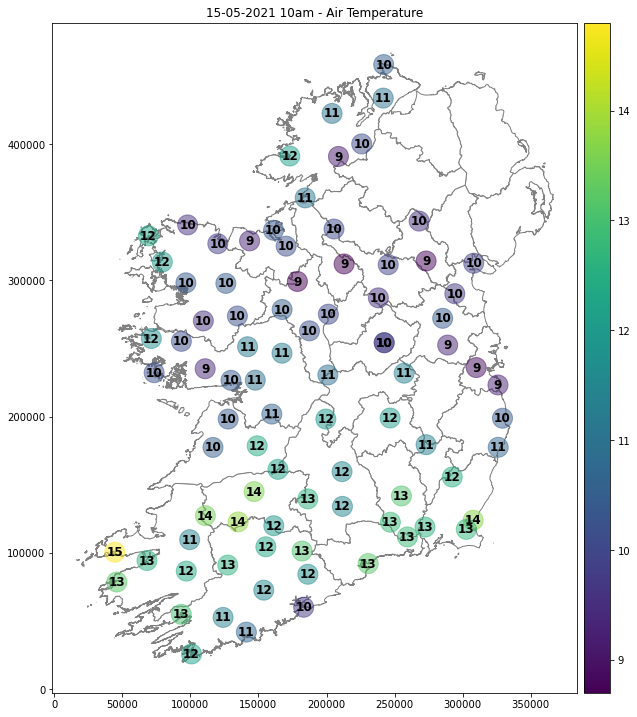

In [5]:
plot_wow_data(gdf_of_interest = gdf_temp_official, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [6]:
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05", 
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10", 
                                                                              type_of_plot="Rainfall Accumulation")

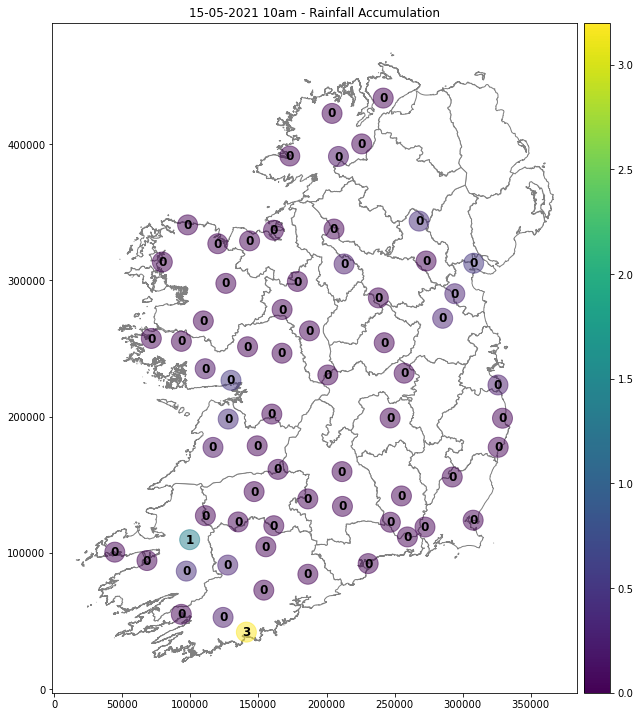

In [7]:
plot_wow_data(gdf_of_interest = gdf_rain_official, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

## Isolation Check

In [9]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np)

In [10]:
radius = 15000 # Radius around each station to check
num_min = 3 # Minimum number of 

radius2 = 50000
num_min2 = 1

flags = titanlib.isolation_check(points, num_min, radius) # more strict requirements
flags2 = titanlib.isolation_check(points, num_min2, radius2) # very lenient requirements

print(flags)
print("\n")
print(flags2)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
custom_points = titanlibcustom.Points(lat_np, long_np)

custom_flags = titanlibcustom.isolation_check(custom_points, num_min, radius)
custom_flags2 = titanlibcustom.isolation_check(custom_points, num_min2, radius2)

print(custom_flags) 
print("\n")
print(custom_flags2) 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 50000, flags = flags2)

## Range Check

### range_check

In [14]:
np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp

# We have the choice between defining a global min and max
# Or defining individual min and max values for each station
# (potential use case: Checking measurement is within the ranges of the stations sensor)

global_min = np.array([10.0]) 
global_max = np.array([15.0])

rng = np.random.default_rng(42)
random_min = rng.integers(low = 0, high = 15, size=len(np_values))
random_max = random_min + 10

In [15]:
flags = titanlib.range_check(np_values, global_min, global_max)
flags

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [16]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 0, flags = flags)

In [17]:
random_flags = titanlib.range_check(np_values, random_min, random_max)
random_flags

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [18]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 0, flags = random_flags)

### range_check_climatology

In [32]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp


import datetime
import time
dt = datetime.datetime(year = 2021, month = 5, day = 15, hour = 10)
date_time_of_int = int(time.mktime(dt.timetuple())) # date and time of interest in UNIX integer format


# We have the choice between defining a global neg and pos
# Or defining individual min and max values for each station

pos_above_mean = np.array([2.5]) # Value above the mean climatological value to accept
neg_below_mean = np.array([-2.5]) # Value above the mean climatological value to accept

In [33]:
flags = titanlib.range_check_climatology(points, np_values, date_time_of_int, pos_above_mean, neg_below_mean)
flags

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

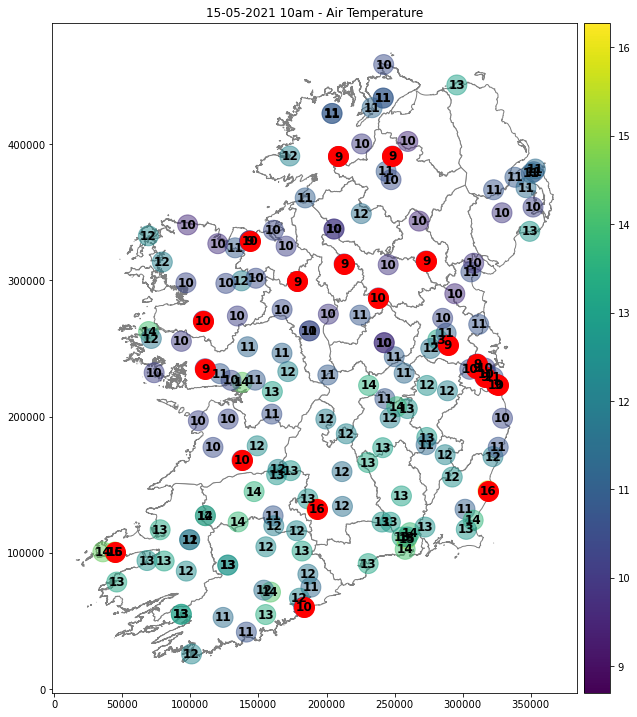

In [34]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = flags)